# __HAND GESTURE CLASSIFICATION__

## [Link to kaggle notebook](https://www.kaggle.com/code/sahiltarlana2601/ie-project)

## **IMPORTING LIBRARIES**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow import keras
from tensorflow.keras import Sequential,layers
from tensorflow.keras.layers import Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.efficientnet import preprocess_input
import sklearn
from sklearn.model_selection import KFold, train_test_split

import pathlib
import os

## __LOADING DATASETS__

In [4]:
data_path = pathlib.Path(r'/kaggle/input/hand-gesture-final/HandGesture/images')

# glob all 'jpg' image files
img_path = list(data_path.glob('**/*.jpg'))

# split label names from file directory
img_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], img_path))

In [5]:
pd_img_path = pd.Series(img_path, name='PATH').astype(str)
pd_img_labels = pd.Series(img_labels, name='LABELS').astype(str)

img_df = pd.merge(pd_img_path, pd_img_labels, right_index=True, left_index=True)

img_df = img_df.sample(frac = 1).reset_index(drop=True)
img_df.head(5243)

PATH   LABELS
0     /kaggle/input/hand-gesture-final/HandGesture/i...  call_me
1     /kaggle/input/hand-gesture-final/HandGesture/i...     rock
2     /kaggle/input/hand-gesture-final/HandGesture/i...  call_me
3     /kaggle/input/hand-gesture-final/HandGesture/i...    paper
4     /kaggle/input/hand-gesture-final/HandGesture/i...    paper
...                                                 ...      ...
2613  /kaggle/input/hand-gesture-final/HandGesture/i...    paper
2614  /kaggle/input/hand-gesture-final/HandGesture/i...       up
2615  /kaggle/input/hand-gesture-final/HandGesture/i...     okay
2616  /kaggle/input/hand-gesture-final/HandGesture/i...     rock
2617  /kaggle/input/hand-gesture-final/HandGesture/i...     rock

[2618 rows x 2 columns]

In [6]:
img_df['LABELS'].value_counts(ascending=True)


up         504
rock       508
call_me    527
paper      539
okay       540
Name: LABELS, dtype: int64

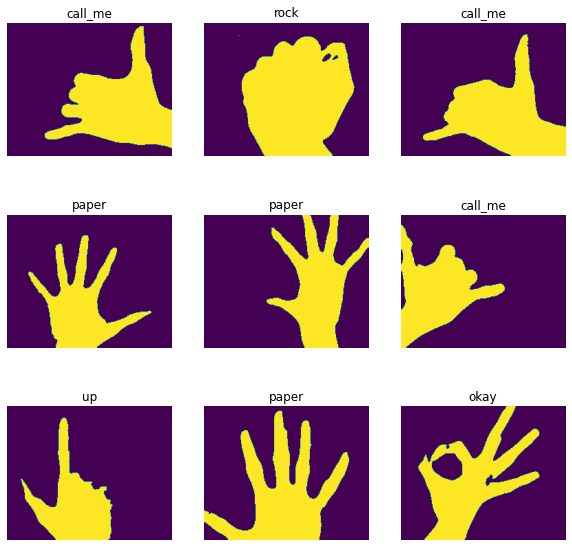

In [7]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(plt.imread(img_df.PATH[i]))
  plt.title(img_df.LABELS[i])
  plt.axis("off")

In [8]:
train_dataset, test_dataset = train_test_split(img_df, train_size=0.9, shuffle=True, stratify=img_df['LABELS'])
print("Number of train data:", train_dataset.shape)
print("Number of test data:", test_dataset.shape)

Number of train data: (2356, 2)
Number of test data: (262, 2)


## __MODEL__

In [10]:
width = 224
height = 224

datagen = ImageDataGenerator(rescale=1/255.0,         
                             horizontal_flip = True, 
                             rotation_range = 20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range = 0.3,
                             validation_split=0.2)

In [11]:
def create_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(width, height , 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_initializer='he_normal')(x)  # Adjust number of units as needed
    x = Dropout(0.4)(x)  # Dropout for regularization
    predictions = Dense(5, activation='softmax',kernel_initializer='glorot_normal')(x)  # 5 output units for 5 classes
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [12]:
# def create_model():
    
#   # load pretrained model 'VGG16'
#   base_model=keras.applications.VGG16(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(width, height ,3))
#   # trainable = False
#   base_model.trainable = False
  
#   model=Sequential()
#   model.add(base_model)
#   model.add(BatchNormalization())   # batch normalization
#   model.add(Dropout(0.4))           # dropout for preventing overfitting
#   model.add(Flatten())
#   model.add(Dense(256,activation='relu',kernel_initializer='he_normal'))
#   model.add(Dropout(0.4))
#   model.add(Dense(5,activation='softmax',kernel_initializer='glorot_normal'))    # softmax classification for 5 labels
  
#   model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
  
#   return model


In [13]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)

In [14]:
# def create_model():
#     # Load pretrained model 'EfficientNetB3'
#     base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(width, height, 3))
#     base_model.trainable = False
    
  

#     model = Sequential()
#     model.add(normalization_layer)  # Apply normalization
#     model.add(base_model)
#     model.add(layers.BatchNormalization())   # Batch normalization
#     model.add(layers.Dropout(0.4))           # Dropout for preventing overfitting
#     model.add(layers.Flatten())
#     model.add(layers.Dense(256, activation='relu', kernel_initializer='he_normal'))
#     model.add(layers.Dropout(0.4))
#     model.add(layers.Dense(10, activation='softmax', kernel_initializer='glorot_normal'))    # Softmax classification for 5 labels

#     model.compile(optimizer='adam',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

#     return model

In [15]:
model = create_model()
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

## __USING KFOLD CROSS VALIDATION FOR TRIANING__

In [16]:
model = create_model()
EPOCHS = 3
histories = []

kfold = KFold(5, shuffle=True, random_state=123)

for f, (trn_ind, val_ind) in enumerate(kfold.split(train_dataset)):
  print(); print("#"*50)
  print("Fold: ",f+1)
  print("#"*50)
  train_ds = datagen.flow_from_dataframe(img_df.loc[trn_ind,:], 
                                         x_col='PATH', y_col='LABELS',
                                         target_size=(width,height),
                                         class_mode = 'categorical', color_mode = 'rgb',
                                         batch_size = 16, shuffle = True)
  val_ds = datagen.flow_from_dataframe(img_df.loc[val_ind,:], 
                                       x_col='PATH', y_col='LABELS',
                                       target_size=(width,height),
                                       class_mode = 'categorical', color_mode = 'rgb',
                                       batch_size = 16, shuffle = True)
  
  # Define start and end epoch for each folds
  fold_start_epoch = f * EPOCHS
  fold_end_epoch = EPOCHS * (f+1)
  
  # fit
  history=model.fit(train_ds, initial_epoch=fold_start_epoch , epochs=fold_end_epoch, 
                    validation_data=val_ds, shuffle=True)
  
  # store history for each folds
  histories.append(history)


##################################################
Fold:  1
##################################################
Found 1884 validated image filenames belonging to 5 classes.
Found 472 validated image filenames belonging to 5 classes.
Epoch 1/3
118/118 [==============================] - 48s 311ms/step - loss: 0.8825 - accuracy: 0.8429 - val_loss: 0.4039 - val_accuracy: 0.8729
Epoch 2/3
118/118 [==============================] - 27s 226ms/step - loss: 0.3722 - accuracy: 0.9220 - val_loss: 0.1556 - val_accuracy: 0.9640
Epoch 3/3
118/118 [==============================] - 27s 226ms/step - loss: 0.2840 - accuracy: 0.9459 - val_loss: 0.0427 - val_accuracy: 0.9852

##################################################
Fold:  2
##################################################
Found 1885 validated image filenames belonging to 5 classes.
Found 471 validated image filenames belonging to 5 classes.
Epoch 4/6
118/118 [==============================] - 31s 264ms/step - loss: 0.1726 - accuracy: 0.9650 

In [ ]:
# model = create_model()
# EPOCHS = 4
# histories = []
# best_val_acc = 0.0
# best_model_path = None

# kfold = KFold(5, shuffle=True, random_state=123)

# for f, (trn_ind, val_ind) in enumerate(kfold.split(train_dataset)):
#   print(); print("#"*50)
#   print("Fold: ",f+1)
#   print("#"*50)

#   # Load the best model weights from the previous fold
#   if f > 0:
#       model.load_weights(f'/kaggle/working/best_model_{f}.h5')
        
#   train_ds = datagen.flow_from_dataframe(img_df.loc[trn_ind,:], 
#                                          x_col='PATH', y_col='LABELS',
#                                          target_size=(width,height),
#                                          class_mode = 'categorical', color_mode = 'rgb',
#                                          batch_size = 16, shuffle = True)
#   val_ds = datagen.flow_from_dataframe(img_df.loc[val_ind,:], 
#                                        x_col='PATH', y_col='LABELS',
#                                        target_size=(width,height),
#                                        class_mode = 'categorical', color_mode = 'rgb',
#                                        batch_size = 16, shuffle = True)
  
    
#   # Define checkpoint callback
#   checkpoint = ModelCheckpoint(f'/kaggle/working/best_model_{f + 1}.h5', monitor='val_accuracy', save_best_only=True, verbose=1)


#   # Define start and end epoch for each folds
#   fold_start_epoch = f * EPOCHS
#   fold_end_epoch = EPOCHS * (f+1)
  
#   # fit
#   history=model.fit(train_ds, initial_epoch=fold_start_epoch , epochs=fold_end_epoch, 
#                     validation_data=val_ds, shuffle=True)

#   max_val_acc = max(history.history['val_accuracy'])

#   if max_val_acc > best_val_acc:
#         best_val_acc = max_val_acc
#         best_model_path = f'best_model_{f + 1}.h5'
    

  
#   # store history for each folds
#   histories.append(history)

In [ ]:
# if best_model_path:
#     model.load_weights(best_model_path)
#     model.save('/kaggle/working/best_overall_model.h5')
#     print(f"Best overall model saved with validation accuracy: {best_val_acc}")

In [17]:
model.save("/kaggle/working/ie_final_3epo_vgg_sahil.h5")

In [ ]:
# 6. Testing
## make test imagedatagenerator and testset for evaluating

In [18]:
test_gen = ImageDataGenerator(rescale=1/255.0) # just rescaling for test data
test_ds = test_gen.flow_from_dataframe(test_dataset, x_col='PATH', y_col='LABELS',
                                       target_size=(width,height),
                                       class_mode = 'categorical', 
                                       color_mode = 'rgb',
                                       batch_size = 16)

Found 262 validated image filenames belonging to 5 classes.


In [19]:
test_loss, test_acc = model.evaluate(test_ds) 
print(f'Model accuracy on test: {test_acc*100:6.2f}')

17/17 [==============================] - 3s 164ms/step - loss: 0.0119 - accuracy: 0.9962
Model accuracy on test:  99.62


In [20]:
def plot_acc_loss(histories):
  acc, val_acc = [], []
  loss, val_loss = [], []
  for i in range(len(histories)):
    acc += histories[i].history['accuracy']
    val_acc += histories[i].history['val_accuracy']

    loss += histories[i].history['loss']
    val_loss += histories[i].history['val_loss']
  
  total_epoch = len(histories) * len(history.epoch) # num of fold * each epoch 
  epochs_range = range(total_epoch)

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

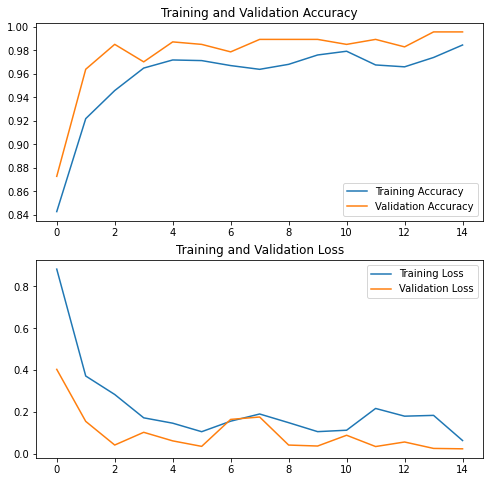

In [21]:
# plot accuracy and loss of train and validation dataset
plot_acc_loss(histories)